In [30]:
# !pip install pyspark -qq
# !pip install tensorflowonspark -qq

In [31]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflowonspark import TFCluster
from sklearn.preprocessing import MinMaxScaler

import os.path
from os import path


# Khởi tạo Spark Session
spark = SparkSession.builder.appName("kafka").getOrCreate()
sc = spark.sparkContext
# Tạo DataFrame mẫu
train_data = spark.read.csv("./train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("./test_data.csv", inferSchema=True, header=True)


In [32]:
training_set = train_data.select("close").toPandas().values
# Thuc hien scale du lieu gia ve khoang 0,1
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [33]:
# Tao du lieu train, X = 60 time steps, Y =  1 time step
def pre_process(data, data_scaled):
    X=[]
    y=[]
    no_of_sample = len(data)

    for i in range(60, no_of_sample):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [34]:
X_train, y_train = pre_process(training_set, training_set_scaled)

In [35]:
X_train.shape[1]

60

In [74]:
def init_model():
    regressor = Sequential()
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [75]:
regressor = init_model()
if path.exists("./mymodel.h5"):
    regressor.load_weights("./mymodel.h5")
else:
    # Con khong thi train
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("./mymodel.h5")

Epoch 1/100
77/77 [==============================] - 7s 40ms/step - loss: 0.0135
Epoch 2/100
77/77 [==============================] - 3s 42ms/step - loss: 0.0041
Epoch 3/100
77/77 [==============================] - 3s 39ms/step - loss: 0.0040
Epoch 4/100
77/77 [==============================] - 3s 41ms/step - loss: 0.0038
Epoch 5/100
77/77 [==============================] - 3s 43ms/step - loss: 0.0034
Epoch 6/100
77/77 [==============================] - 3s 40ms/step - loss: 0.0029
Epoch 7/100
77/77 [==============================] - 3s 40ms/step - loss: 0.0033
Epoch 8/100
77/77 [==============================] - 3s 37ms/step - loss: 0.0026
Epoch 9/100
77/77 [==============================] - 3s 38ms/step - loss: 0.0026
Epoch 10/100
77/77 [==============================] - 3s 40ms/step - loss: 0.0027
Epoch 11/100
77/77 [==============================] - 3s 42ms/step - loss: 0.0026
Epoch 12/100
77/77 [==============================] - 3s 42ms/step - loss: 0.0022
Epoch 13/100
77/77 [=====

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
test_set = test_data.select("close").toPandas().values
a = training_set[len(training_set)-60:]
dataset_test = np.concatenate((a, test_set), axis=0)

test_scaled = scaler.transform(dataset_test)

In [66]:
X_test, y_test = pre_process(dataset_test, test_scaled)

In [57]:
model_load= init_model()
model_load.load_weights("./mymodel.h5")


In [58]:
a= regressor.predict(X_test)

6/6 [==============================] - 0s 14ms/step


In [46]:
scaler.inverse_transform(np.array(a))

array([[53639.973],
       [54541.266],
       [55452.38 ],
       [55989.   ],
       [56117.04 ],
       [55738.88 ],
       [55071.49 ],
       [54607.062],
       [54403.234],
       [54343.75 ],
       [54266.566],
       [54253.57 ],
       [54666.93 ],
       [55425.59 ],
       [56589.62 ],
       [57215.664],
       [57103.2  ],
       [56216.273],
       [55359.22 ],
       [54940.445],
       [54891.234],
       [54734.703],
       [54317.668],
       [53821.72 ],
       [53412.43 ],
       [53036.902],
       [52637.863],
       [52317.973],
       [52261.51 ],
       [52410.047],
       [52747.844],
       [53138.668],
       [53106.715],
       [52796.234],
       [52452.23 ],
       [52127.508],
       [51911.473],
       [51832.8  ],
       [51857.508],
       [51885.445],
       [51857.9  ],
       [51821.844],
       [51872.305],
       [51968.26 ],
       [52070.45 ],
       [52188.016],
       [52211.547],
       [52400.758],
       [52508.08 ],
       [52461.01 ],


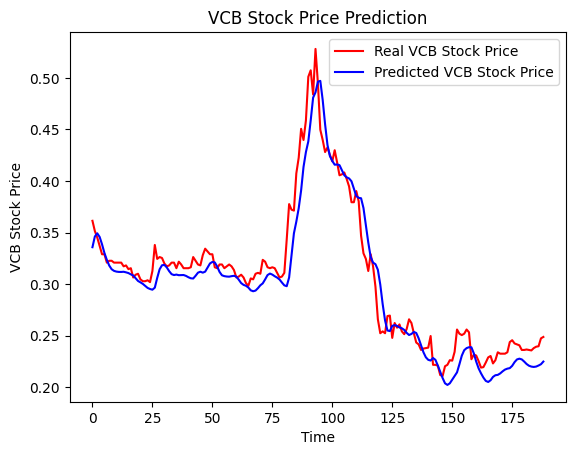

In [60]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y_test, color = 'red', label = 'Real VCB Stock Price')
plt.plot(a, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
plt.savefig('svm_result.jpg')
plt.show()


In [87]:
def predict_future(data):
    inputs = data
    # inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    # print(inputs)
    list_predict = []

    i = 0
    while i<28:
        X_test = []
        no_of_sample = len(data)

        # Lay du lieu cuoi cung
        X_test.append(inputs[no_of_sample - 60:no_of_sample, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        # print(X_test)
        # Du doan gia
        predicted_stock_price = regressor.predict(X_test)

        # chuyen gia tu khoang (0,1) thanh gia that
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

        # Them ngay hien tai vao
        data = np.concatenate((data, predicted_stock_price), axis=0)
        inputs = data
        # inputs = inputs.reshape(-1, 1)
        inputs = scaler.transform(inputs)

        list_predict.append(predicted_stock_price[0][0])

        # print('Stock price ' + str(i+3) + '/10/2019 of VCB : ', predicted_stock_price[0][0])
        i = i +1

    return list_predict

In [88]:
data_test = test_set[len(test_set)-28-60:len(test_set)-28]
y_pre=predict_future(data_test)

1/1 [==============================] - 0s 25ms/step


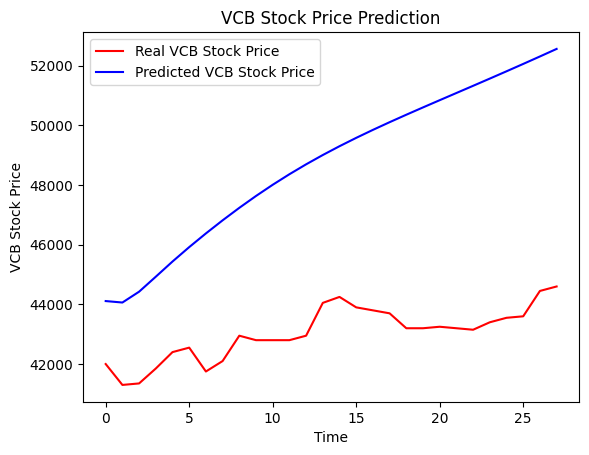

In [89]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(test_set[len(test_set)-28:], color = 'red', label = 'Real VCB Stock Price')
plt.plot(y_pre, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
# plt.savefig('svm_result.jpg')
plt.show()